**Semantic Segmentation of Cityscapes Dataset**

In [4]:
##########################GENERAL IMPORTS###########################################
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os, cv2, imageio
import tensorflow as tf

from tqdm import tqdm
from skimage import io
from glob import glob

In [3]:
##########################KERAS IMPORTS###########################################
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, UpSampling2D
from keras.layers.advanced_activations import ELU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.models import load_model, Model

Using TensorFlow backend.


In [5]:
%matplotlib inline

np.random.seed(100)
tf.set_random_seed(100)

t_path = '../input/cityscapes_data/cityscapes_data/train'
v_path = '../input/cityscapes_data/cityscapes_data/val'

100%|██████████| 500/500 [00:01<00:00, 352.53it/s]


Text(0.5, 1.0, 'Validation Mask')

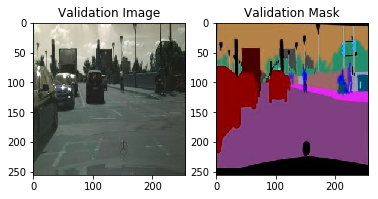

In [11]:
#############################DEFINING IMAGE AND MASK PATHS########################
train_images = []
train_masks = []
val_images = []
val_masks = []
def load_images(path):
    temp_img,temp_mask = [],[]
    images = glob(os.path.join(path,'*.jpg'))
    for i in tqdm(images):
        i = cv2.imread(i)
        i = cv2.normalize(i, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
        img = i[:,:256]
        msk = i[:,256:]  
        temp_img.append(img)
        temp_mask.append(msk)
    return temp_img,temp_mask

train_images,train_masks = load_images(t_path)
val_images,val_masks = load_images(v_path)

# print (len(train_masks1))

img, axis = plt.subplots(nrows = 1, ncols = 2)
axis[0].imshow(val_images[0])
axis[0].set_title('Validation Image')
axis[1].imshow(val_masks[0])
axis[1].set_title('Validation Mask')


In [ ]:
#######################################U_NET######################################
input_img = Input((256, 256, 3), name = 'img')

conv_1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (input_img)
conv_1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (conv_1)
pool_1 = MaxPooling2D(pool_size = (2, 2)) (conv_1)

conv_2 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (pool_1)
conv_2 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (conv_2)
pool_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)

conv_3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (pool_2)
conv_3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (conv_3)
pool_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)

conv_4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (pool_3)
conv_4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (conv_4)
pool_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)

conv_5 = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (pool_4)
conv_5 = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (conv_5)


upsample_6 = concatenate([UpSampling2D(size=(2, 2))(conv_5), conv_4], axis=3)
conv_6 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (upsample_6)
conv_6 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (conv_6)

upsample_7 = concatenate([UpSampling2D(size=(2, 2))(conv_6), conv_3], axis=3)
conv_7 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (upsample_7)
conv_7 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (conv_7)

upsample_8 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_2], axis=3)
conv_8 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (upsample_8)
conv_8 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (conv_8)

upsample_9 = concatenate([UpSampling2D(size=(2, 2))(conv_8), conv_1], axis=3)
conv_9 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (upsample_9)
conv_9 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal') (conv_9)

output = Conv2D(3, (3, 3), activation = 'softmax', padding = 'same') (conv_9)
    
###########TRAINING MODEL WITH INPUT IMAGE AND OUPUT DERIVED ABOVE######
model = Model(inputs = [input_img], outputs = [output])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) 
model.summary()
print (input_img.shape)
print (output.shape)

In [ ]:
##############################CALLBACKS AND RESULTS#####################
callbacks = [
    EarlyStopping(patience = 12, verbose = 1),
    ReduceLROnPlateau(patience = 3, verbose = 1),
    ModelCheckpoint('sem_seg_model.h5', verbose = 1, save_best_only = True)
]

results = model.fit(np.array(train_images), np.array(train_masks), batch_size = 16, epochs = 10, callbacks = callbacks, validation_data = (np.array(val_images), np.array(val_masks)))

In [ ]:
############################MODEL SAVE##################################					
model.save('final_sem_seg_model.h5')

[0 0 1 ... 1 0 1]
[0 1 1 ... 1 0 1]


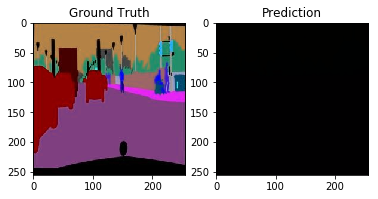

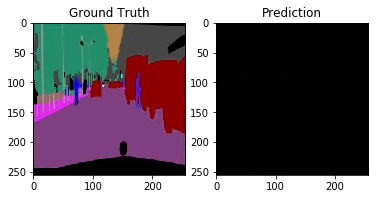

In [16]:
########################TEST PART#######################################
num = 0
for num in (0, 2):
    pred = model.predict(np.expand_dims(val_images[num], 0))
    pred = pred.flatten()
    pred = np.array([1 if i >= 0.33 else 0 for i in pred])
    print (pred)
    img, axis = plt.subplots(nrows = 1, ncols = 2)
    axis[0].imshow(val_masks[num].reshape(256, 256, 3))
    axis[0].set_title('Ground Truth')
    axis[1].imshow(pred.reshape(256, 256, 3))
    axis[1].set_title('Prediction')  
    num = num + 1